In [1]:
import os, sys, re, gc, glob

# set working dir
WORKING_DIR = re.sub('jdi-qasp-ml.*$','',os.path.normpath(os.getcwd())) + 'jdi-qasp-ml'
os.chdir(WORKING_DIR)

import torch
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm, trange
from sklearn.metrics import confusion_matrix
import json

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

from tqdm.auto import tqdm, trange
from utils import JDNDataset, JDIModel, get_grey_image, assign_labels, logger, maximize_window, DatasetBuilder
from time import sleep
from flask import jsonify

import datetime as dt
import requests

START_DT = dt.datetime.now()

2021-06-20 00:02:21,128 -INFO - config:config.py:16 - Module utils.config was loaded
2021-06-20 00:02:21,130 -INFO - common:common.py:618 - Module utils.common is loaded...
2021-06-20 00:02:21,131 -INFO - hidden:hidden.py:121 - hidden module is loaded
2021-06-20 00:02:21,137 -INFO - features_builder:features_builder.py:305 - feature_bilder module is loaded...
2021-06-20 00:02:21,140 -INFO - dataset_builder:dataset_builder.py:207 - dataset package is loaded...
2021-06-20 00:02:21,142 -INFO - dataset:dataset.py:277 - dataset module is loaded...


In [2]:
SITE_ROOT = 'https://www.google.com'
#SITE_ROOT = 'https://cnews.ru'

SAVE_SCREEN = True
WAIT_TIME_SECONDS = 7
HEADLESS = True #False

PREDICT_URL = 'http://localhost:5000/predict'


### getting json

In [3]:
class DSLogin(DatasetBuilder):
    def setUp(self, driver):
        """
            This method may be overwitten if you need to login to the site
            and navigate to a specific url,
            otherwise it just returns 
        """
        logger.info(f'getting url: {self.url}')
        self.driver.get(self.url)
        sleep(3.0)
        
#         driver.find_element_by_id("user-icon").click()
#         driver.find_element_by_id("name").send_keys(LOGIN)
#         driver.find_element_by_id("password").send_keys(PASSWORD)
#         driver.find_element_by_id("login-button").click()
#         sleep(3.0)
        maximize_window(driver=driver, extend_pix=0)
        
with DSLogin(url=SITE_ROOT, dataset_name='dummy', headless=True) as ds:
    login_df = ds.dataset
    login_json = ds.dataset_json
  

2021-06-20 00:02:21,458 -WARNING - dataset_builder:dataset_builder.py:75 - The default dataset name "dummy" will be used
2021-06-20 00:02:21,459 -INFO - dataset_builder:dataset_builder.py:86 - Create directories to save the dataset
2021-06-20 00:02:21,460 -INFO - dataset_builder:dataset_builder.py:123 - Creating driver
2021-06-20 00:02:22,503 -INFO - dataset_builder:dataset_builder.py:131 - Chrome web driver is created
2021-06-20 00:02:22,503 -INFO - <ipython-input-3-fb967ab4eedc>:<ipython-input-3-fb967ab4eedc>:8 - getting url: https://www.google.com
2021-06-20 00:02:26,045 -INFO - common:common.py:75 - Window maximized
2021-06-20 00:02:26,045 -INFO - dataset_builder:dataset_builder.py:134 - save scrinshot: dataset/images/dummy.png
2021-06-20 00:02:26,074 -INFO - dataset_builder:dataset_builder.py:178 - Collect features using JS script
2021-06-20 00:02:26,230 -INFO - dataset_builder:dataset_builder.py:186 - Save html to dataset/html/dummy.html
2021-06-20 00:02:26,245 -INFO - dataset_bu

In [4]:
len(json.dumps(login_json))

1580391

[{'attributes': {'itemscope': '',
   'itemtype': 'http://schema.org/WebPage',
   'lang': 'ru'},
  'displayed': True,
  'element_id': '8913922086365460779629721900',
  'height': 600,
  'onmouseenter': None,
  'onmouseover': None,
  'parent_id': None,
  'style': ['align-content',
   'align-items',
   'align-self',
   'alignment-baseline',
   'animation-delay',
   'animation-direction',
   'animation-duration',
   'animation-fill-mode',
   'animation-iteration-count',
   'animation-name',
   'animation-play-state',
   'animation-timing-function',
   'appearance',
   'backdrop-filter',
   'backface-visibility',
   'background-attachment',
   'background-blend-mode',
   'background-clip',
   'background-color',
   'background-image',
   'background-origin',
   'background-position',
   'background-repeat',
   'background-size',
   'baseline-shift',
   'block-size',
   'border-block-end-color',
   'border-block-end-style',
   'border-block-end-width',
   'border-block-start-color',
   'borde
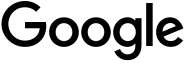
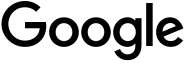
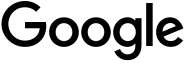

In [5]:
login_json

In [6]:
PREDICT_URL

'http://localhost:5000/predict'

### Predict: sending json to backend and getting predictions

In [7]:
%%time

response = requests.post(
    PREDICT_URL, data=json.dumps(login_json)
)

if response.status_code == 200:
    display(json.loads(response.text))
else:
    raise Exception(response.text)

[{'element_id': '0169082429365460786029863302',
  'x': 194.40625,
  'y': 461.0,
  'width': 411.171875,
  'height': 47.0,
  'predicted_label': 'link',
  'predicted_probability': 0.9130814672,
  'sort_key': 19325.078125},
 {'element_id': '0545734146365460786009293432',
  'x': 453.078125,
  'y': 508.0,
  'width': 206.53125,
  'height': 46.0,
  'predicted_label': 'link',
  'predicted_probability': 0.9999965429,
  'sort_key': 9500.4375},
 {'element_id': '6931657439365460787040209995',
  'x': 222.703125,
  'y': 554.0,
  'width': 172.015625,
  'height': 46.0,
  'predicted_label': 'link',
  'predicted_probability': 0.9997652173,
  'sort_key': 7912.71875},
 {'element_id': '0454309988365460782288234857',
  'x': 140.375,
  'y': 508.0,
  'width': 114.84375,
  'height': 46.0,
  'predicted_label': 'link',
  'predicted_probability': 0.9997652173,
  'sort_key': 5282.8125},
 {'element_id': '8130058892365460781503711498',
  'x': 341.390625,
  'y': 508.0,
  'width': 111.6875,
  'height': 46.0,
  'predict

Wall time: 2.44 s


In [8]:
response

<Response [200]>

In [9]:
print('Elapsed time:', dt.datetime.now() - START_DT)

Elapsed time: 0:00:08.308783
